In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import ERFutils
import scipy.signal as signal
import cf_xarray as cfxr
from datetime import timedelta

dask.config.set(**{'array.slicing.split_large_chunks': True})

Load ssp585 as training data...
	Load 1pctCO2 run for scaling...
(0.2289, 0.1527, 0.0)
(0.2961, 0.1813, -0.0)


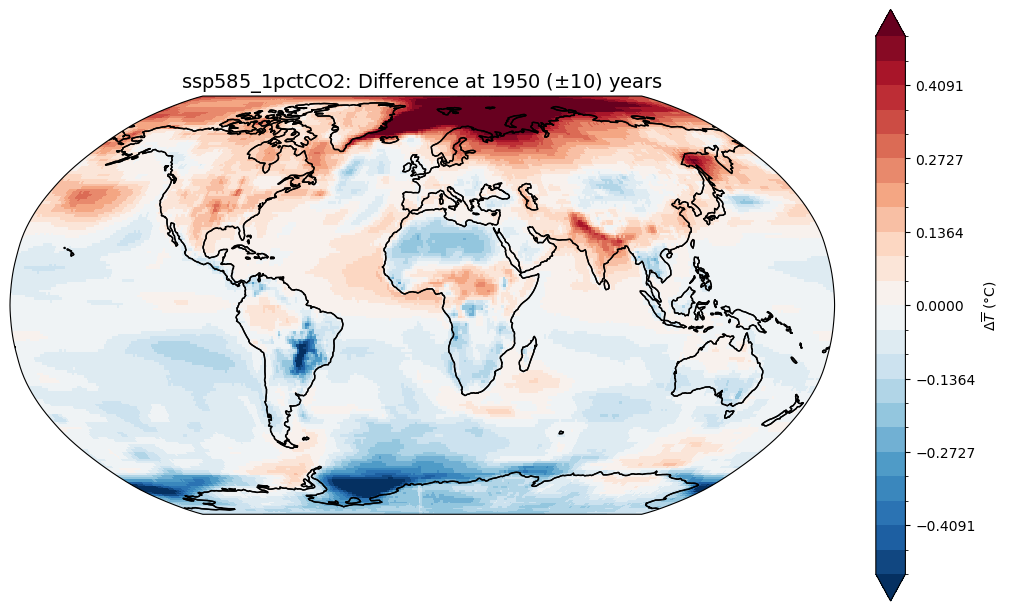

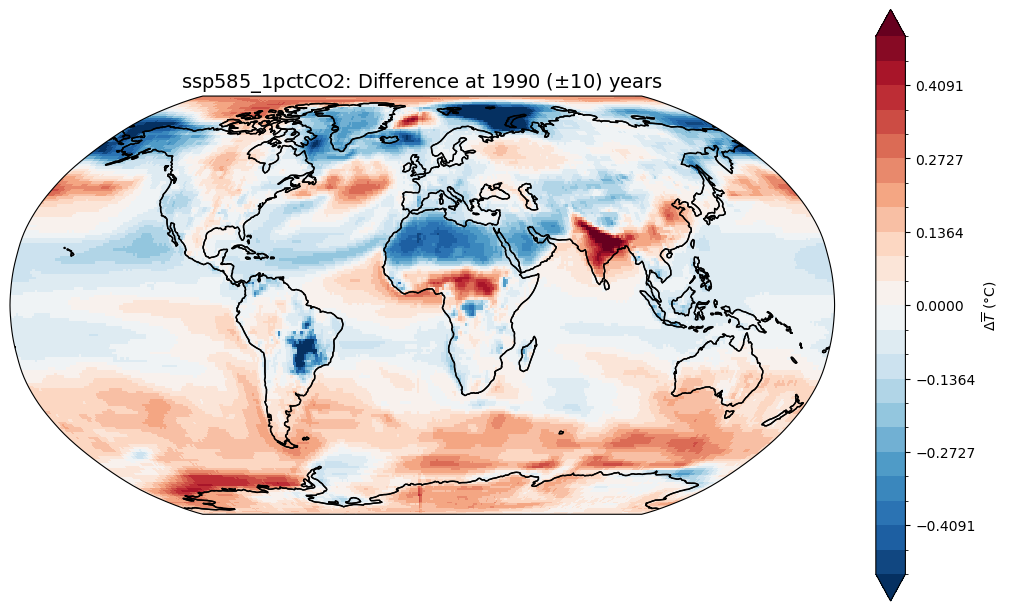

In [2]:
model_set = ERFutils.model_set
A = ERFutils.A
ds_out = ERFutils.ds_out

scale_id = ['1pctCO2']#,'ssp126','ssp245','ssp370','ssp585']
train_id = ['ssp585']

output_path = ERFutils.path_to_ERF_outputs

# Iterate over training and testing datasets
for train in train_id:
    print(f'Load {train} as training data...')
    for scale in scale_id:
        print(f'\tLoad {scale} run for scaling...')

        # Load patterns and CMIP tas data
        pattern_ds_path = f'{output_path}Patterns/pattern_{train}_all_ds.nc4'
        pattern_ds = xr.open_dataset(pattern_ds_path)
        tas_CMIP_path = f'{output_path}tas/tas_CMIP_{scale}_all_ds.nc4'
        tas_CMIP = xr.open_dataset(tas_CMIP_path) 
        
        # Perform pattern scaling
        if 'model' in pattern_ds:
            pattern = pattern_ds.mean(dim = ['model'])
        else:
            pattern = pattern_ds
        tas_CMIP_glob = tas_CMIP.weighted(A).mean(dim = ['lat','lon']).mean(dim = ['model'])
        pattern_manip = pattern.assign_coords({'s':tas_CMIP_glob.s}).stack(allpoints=['lat','lon'])
        
        scaled_vals = np.zeros((len(tas_CMIP_glob.tas),len(pattern_manip.pattern)))
        for i in range(len(tas_CMIP_glob.tas.values)):
            scaled_vals[i,:] = pattern_manip.pattern.values * tas_CMIP_glob.tas.values[i]

        scaled_pattern = xr.Dataset(coords={'lon': ('lon', pattern.lon.values),
                                      'lat': ('lat', pattern.lat.values),
                                      's':tas_CMIP_glob.s.values})

        scaled_pattern = scaled_pattern.stack(allpoints=['lat','lon'])
        scaled_pattern['tas'] = (('s','allpoints'),scaled_vals)
        scaled_pattern = scaled_pattern.unstack('allpoints')
        scaled_pattern.to_netcdf(f'{output_path}Spatial Results/res_pattern_spatial_{train}_{scale}_all_ds.nc4') 
            
        if 'ssp' in scale:
            start_yr1, plot_yr1, end_yr1 = 2040, 2050, 2060
            start_yr2, plot_yr2, end_yr2 = 2080, 2090, 2100
        elif 'hist' in scale:
            start_yr, plot_yr, end_yr = 1850, 1975, 2015
        else: # 1pctCO2
            start_yr1, plot_yr1, end_yr1 = 1940, 1950, 1960
            start_yr2, plot_yr2, end_yr2 = 1980, 1990, 2000

        model_color = ERFutils.model_color
        type_color = ERFutils.type_color
        ERFutils.plot_pattern(scaled_pattern, train, scale, tas_CMIP, plot_yr1, 10, save_fig = False)
        ERFutils.plot_pattern(scaled_pattern, train, scale, tas_CMIP, plot_yr2, 10, save_fig = False)
        
        MSE1, RMSE1, MAE1, bias1 = ERFutils.calc_error_metrics(tas_CMIP, scaled_pattern, start_yr1, end_yr1, mean_GF = False, pattern = True)
        print(f'({round(RMSE1,4)}, {round(float(MAE1),4)}, {round(float(bias1),4)})')
        MSE2, RMSE2, MAE2, bias2 = ERFutils.calc_error_metrics(tas_CMIP, scaled_pattern, start_yr2, end_yr2, mean_GF = False, pattern = True)
        print(f'({round(RMSE2,4)}, {round(float(MAE2),4)}, {round(float(bias2),4)})')